## **Convolutional Neural Networks**

In [1]:
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])
batch_size = 64

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16276753.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 521970.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4402850.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10438645.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes = 10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16, # kernel size 5x5 da applicare sul singolo channel
            kernel_size=5,
            padding=0
        ) # output da qui --> (B, 16, 28-5+0+1=24, 28-5+0+1=24)
        # dopo questo applicherò il pooling
        # input a conv2 --> (B, 16, 24/2=12, 24/2=12)
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=5,
            padding=0
        ) # output da qui --> (B, 32, 12-5+0+1=8, 12-5+0+1=8)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(2) # kernel size 2x2
        self.flatten = nn.Flatten()
        # prima di linear applicheremo il pool --> (B, 32, 4, 4) -> (B, 32, 4, 4)
        # input_features per linear è: 32*10*10
        self.linear1 = nn.Linear(32*4*4, 128)
        self.head = nn.Linear(128, num_classes)

    def forward(self, x):
        # prima parte convoluzionale
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation(x)
        # seconda parte convoluzionale
        x = self.conv2(x)
        x = self.pool(x)
        x = self.activation(x)
        # flatten
        x = self.flatten(x)
        x = self.linear1(x)
        logits = self.head(x)
        return logits

In [ ]:
model = Net(num_classes=10)

# check if everythig is fine
x = torch.rand((2, 1, 28, 28))
logits = model(x)
print(logits.shape)

torch.Size([2, 10])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
device = "cuda:0"
model.to(device);

In [ ]:
# Train the neural network
num_epochs = 5
log_every_n_iter = 250
for epoch in range(num_epochs):
  # train loop
  model.train()
  epoch_loss = 0.0
  print(f"Epoch: {epoch}")
  for i, batch in enumerate(train_loader, 0):
    # batch --> (images, targets)
    x, targets = [el.to(device) for el in batch]
    # set optimizer a zero
    optimizer.zero_grad()
    # forward pass
    logits = model(x)
    # calcolo della loss
    loss = criterion(logits, targets)
    # backward pass
    loss.backward()
    # optimizer step --> update weights
    optimizer.step()
    epoch_loss += loss.item()
    if (i+1) % log_every_n_iter == 0:    # Print every log_every_n_iter mini-batches
        print(f"> iter [{i+1}/{len(train_loader)}] - train_loss={epoch_loss/log_every_n_iter:.4f}")
        epoch_loss = 0.0
    # test loop
  model.eval()
  test_loss = []
  total, correct = 0, 0
  with torch.no_grad():
    for batch in test_loader:
      x, targets = [el.to(device) for el in batch]
      logits = model(x)
      loss = criterion(logits, targets)
      test_loss.append(loss.item())
      # ottengo gli indici dove trovo la max probabilità
      _, preds = torch.max(logits.data, 1)
      total += targets.size(0)
      correct += (preds == targets).sum().item()

  print("Test report:")
  print(f"\t test_loss={sum(test_loss)/len(test_loss):.4f} - test_accuracy={correct/total:.4f}")

  print(" \n *************** \n")


print('Finished Training')

Epoch: 0
> iter [250/938] - train_loss=2.2950
> iter [500/938] - train_loss=2.2596
> iter [750/938] - train_loss=2.2157
Test report:
test_loss=2.1339 - test_accuracy=0.5664
 
 *************** 

Epoch: 1
> iter [250/938] - train_loss=2.0932
> iter [500/938] - train_loss=1.9654
> iter [750/938] - train_loss=1.7647
Test report:
test_loss=1.3856 - test_accuracy=0.7362
 
 *************** 

Epoch: 2
> iter [250/938] - train_loss=1.2478
> iter [500/938] - train_loss=0.9799
> iter [750/938] - train_loss=0.7826
Test report:
test_loss=0.6073 - test_accuracy=0.8455
 
 *************** 

Epoch: 3
> iter [250/938] - train_loss=0.5924
> iter [500/938] - train_loss=0.5380
> iter [750/938] - train_loss=0.4997
Test report:
test_loss=0.4275 - test_accuracy=0.8769
 
 *************** 

Epoch: 4
> iter [250/938] - train_loss=0.4407
> iter [500/938] - train_loss=0.4196
> iter [750/938] - train_loss=0.3976
Test report:
test_loss=0.3542 - test_accuracy=0.8945
 
 *************** 

Finished Training


### Inference

In [ ]:
idx = random.randint(0, len(test_dataset))
img, target = test_dataset[idx]
print(img.shape)
# we need to augment the first dimension --> from (C, H, W) -> (B, C, H, W)
x = img.unsqueeze(0)
print(x.shape)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [ ]:
import torch.nn.functional as F

with torch.no_grad():
  model.eval()
  logits = model(x.to(device))
  probs = F.softmax(logits, 1)
  print(probs.data)
  pred_prob, pred_class= torch.max(probs.data, 1)
  print(pred_class, pred_prob)

tensor([[3.0209e-05, 9.6808e-01, 2.5137e-03, 6.9704e-03, 8.4398e-04, 1.5312e-03,
         1.1032e-03, 1.0808e-02, 3.0216e-03, 5.0998e-03]], device='cuda:0')
tensor([1], device='cuda:0') tensor([0.9681], device='cuda:0')


In [ ]:
np_img = img.numpy() # (C, W, H)
np_img = np.transpose(np_img, (1, 2, 0)) # (W, H, C)
print(np_img.shape)

(28, 28, 1)


Predicted class is 1 with prob=0.9681


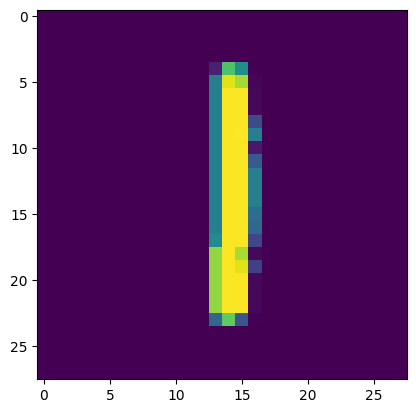

In [ ]:
print(f"Predicted class is {pred_class[0]} with prob={pred_prob[0]:.4f}")
plt.imshow(np_img)